In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../")

In [3]:
import numpy as np
import torch
import seaborn as sns
import pandas as pd
from copy import deepcopy
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from uq360.algorithms.homoscedastic_gaussian_process_regression import HomoscedasticGPRegression
from uq360.algorithms.ucc_recalibration import UCCRecalibration
from uq360.metrics import picp, mpiw, compute_regression_metrics
from uq360.metrics import GainUncertaintyCharacteristicsCurve as gucc

In [4]:
from uq360.datasets import MEPSDataset

In [5]:
data = MEPSDataset().data()

In [6]:
categorical_features = ['REGION','SEX','MARRY',
                                 'FTSTU','ACTDTY','HONRDC','RTHLTH','MNHLTH','HIBPDX','CHDDX','ANGIDX',
                                 'MIDX','OHRTDX','STRKDX','EMPHDX','CHBRON','CHOLDX','CANCERDX','DIABDX',
                                 'JTPAIN','ARTHDX','ARTHTYPE','ASTHDX','ADHDADDX','PREGNT','WLKLIM',
                                 'ACTLIM','SOCLIM','COGLIM','DFHEAR42','DFSEE42','ADSMOK42',
                                 'PHQ242','EMPST','POVCAT','INSCOV']

In [7]:
data = pd.get_dummies(data, columns=categorical_features, prefix_sep='=')

In [8]:
data = data[data["UTILIZATION"] >=0]

In [9]:
# Reset index to consecutive integers
data.reset_index(drop=True, inplace=True)
# Drop panel number (not meant to be predictive) and sample weights
data.drop(columns = ['PERWT15F'], inplace=True)
data

,AGE,RACE,PCS42,MCS42,K6SUM42,UTILIZATION,REGION=1,REGION=2,REGION=3,REGION=4,...,EMPST=3,EMPST=4,POVCAT=1,POVCAT=2,POVCAT=3,POVCAT=4,POVCAT=5,INSCOV=1,INSCOV=2,INSCOV=3
0,53,White,25.93,58.47,3,15,0,1,0,0,...,0,1,1,0,0,0,0,0,1,0
1,56,White,20.42,26.57,17,10,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
2,23,White,53.12,50.33,7,3,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
3,3,White,-1.00,-1.00,-1,7,0,1,0,0,...,0,0,0,1,0,0,0,0,1,0
4,27,Non-White,-1.00,-1.00,-1,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15808,25,Non-White,56.71,62.39,0,0,0,0,1,0,...,0,0,1,0,0,0,0,1,0,0
15809,25,Non-White,56.71,62.39,0,2,0,0,1,0,...,0,1,1,0,0,0,0,1,0,0
15810,2,White,-1.00,-1.00,-1,3,0,0,1,0,...,0,0,1,0,0,0,0,0,1,0
15811,54,Non-White,43.97,42.45,24,8,1,0,0,0,...,0,0,0,0,1,0,0,0,1,0


In [10]:
def race(row):
    if row['RACE'] == 'White':
        return 1.0
    return 0.0

In [11]:
data["RACE"] = data.apply(lambda row: race(row), axis=1)

In [12]:
data = data.dropna()

In [13]:
# Separate target variable
y = np.log( 1.0 + data.pop('UTILIZATION'))
a = data['RACE']
# Split data into training and test sets
from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test, a_train, a_test = train_test_split(data, y, a, random_state=0)
df_train, df_val, y_train, y_val, a_train, a_val = train_test_split(df_train, y_train, a_train, random_state=0)

<AxesSubplot:xlabel='UTILIZATION'>

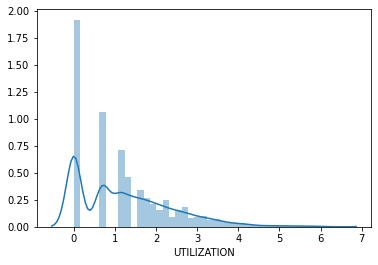

In [14]:
kwargs = {'cumulative': False}
sns.distplot(y, hist_kws=kwargs, kde_kws=kwargs)

In [15]:
normalizer_y = StandardScaler()
y_train = normalizer_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = normalizer_y.transform(y_test.values.reshape(-1, 1))
normalizer_X = MinMaxScaler()
X_train = normalizer_X.fit_transform(df_train)
X_test = normalizer_X.transform(df_test)

<AxesSubplot:>

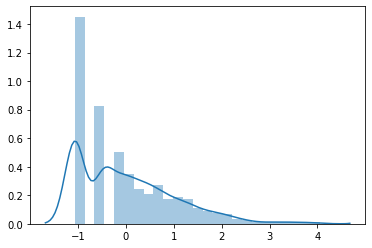

In [16]:
kwargs = {'cumulative': False}
sns.distplot(y_test, hist_kws=kwargs, kde_kws=kwargs)

In [17]:
def create_res_df(method_name, y_test, y_mean, y_lower, y_upper):
    results = {"Overall": compute_regression_metrics(y_test, y_mean, y_lower, y_upper)}
    results["White"] = compute_regression_metrics(y_test[a_test==1.0], y_mean[a_test==1.0], y_lower[a_test==1.0], y_upper[a_test==1.0])
    results["Non-white"] = compute_regression_metrics(y_test[a_test==0.0], y_mean[a_test==0.0], y_lower[a_test==0.0], y_upper[a_test==0.0])

    total = [method_name,
             "Overall",
             results["Overall"]["rmse"],
             results["Overall"]["r2"],
             results["Overall"]["picp"],
             results["Overall"]["mpiw"],
             100*results["Overall"]["auucc_gain"]]
    white = [method_name,
             "White",
             results["White"]["rmse"],
             results["White"]["r2"],
             results["White"]["picp"],
             results["White"]["mpiw"],
             100*results["White"]["auucc_gain"]]
    nonwhite = [method_name,
             "Non-white",
             results["Non-white"]["rmse"],
             results["Non-white"]["r2"],
             results["Non-white"]["picp"],
             results["Non-white"]["mpiw"],
             100*results["Non-white"]["auucc_gain"]]
    res = pd.DataFrame([total, white, nonwhite], columns=['Method', 'Group', 'rmse', 'r2', 'Avg. Coverage', 'Avg. Width', '% AUUCC Gain'])
    return res

In [18]:
all_results = pd.DataFrame(columns=['Method', 'Group', 'rmse', 'r2', 'Avg. Coverage', 'Avg. Width', '% AUUCC Gain'])

# Train GP Regression

In [19]:
gp_model = HomoscedasticGPRegression()

In [20]:
ids = np.random.randint(X_train.shape[0], size=1000)
gp_model = gp_model.fit(X_train[ids], y_train[ids])

In [21]:
gp_y_test_mean, gp_y_test_lower, gp_y_test_upper = gp_model.predict(X_test)[:3]

In [22]:
gp_res = create_res_df("GP", y_test.squeeze(), gp_y_test_mean, gp_y_test_lower, gp_y_test_upper)

In [23]:
gp_res

,Method,Group,rmse,r2,Avg. Coverage,Avg. Width,% AUUCC Gain
0,GP,Overall,0.798368,0.377280,0.950683,3.080116,2.859758
1,GP,White,0.849492,0.367940,0.937111,3.143033,1.663640
2,GP,Non-white,0.767312,0.330276,0.958516,3.043801,3.220036


# Post-hoc calibration using a held out set

In [24]:
# Let us now train UCCRecalibration models to calibrate BUQ model on white group separately to achieve equalized 
# coverage. We use the the held out calibration to train these models.

In [25]:
y_val = normalizer_y.transform(y_val.values.reshape(-1, 1))
X_val = normalizer_X.transform(df_val)

In [26]:
calib_gp_for_white = UCCRecalibration(base_model=gp_model).fit(X_val[a_val==1.0], y_val[a_val==1.0])
calib_gp_y_test_mean_white, calib_gp_y_test_lower_white, calib_gp_y_test_upper_white = calib_gp_for_white.predict(X_test[a_test==1.0], missrate=0.03)[:3]

res_calib_gp_white = compute_regression_metrics(y_test[a_test==1.0].squeeze(), calib_gp_y_test_mean_white, calib_gp_y_test_lower_white, calib_gp_y_test_upper_white)

In [27]:
gp_res.append(pd.Series(["GP",
             "Calib White",
             res_calib_gp_white["rmse"],
             res_calib_gp_white["r2"],
             res_calib_gp_white["picp"],
             res_calib_gp_white["mpiw"],
             100*res_calib_gp_white["auucc_gain"]], index = gp_res.columns), ignore_index=True)

,Method,Group,rmse,r2,Avg. Coverage,Avg. Width,% AUUCC Gain
0,GP,Overall,0.798368,0.377280,0.950683,3.080116,2.859758
1,GP,White,0.849492,0.367940,0.937111,3.143033,1.663640
2,GP,Non-white,0.767312,0.330276,0.958516,3.043801,3.220036
3,GP,Calib White,0.849492,0.367940,0.968901,3.743788,1.665343
